In [1]:
import sys

import cv2
import numpy as np
from sklearn.cluster import KMeans

sys.path.append('../../src')
from common import common, utils
from common.transform import Homography
from common.video import Capture

In [2]:
# file path
room_num = "08"
date = "20210915"
video_path = common.root + f"/video/{room_num}/{date}/01.mp4"
field_path = common.data_dir + "/{}/field.png".format(room_num)
print(video_path)
print(field_path)

C:\Users\k2111\program\research/video/08/20210915/01.mp4
C:\Users\k2111\program\research\data/08/field.png


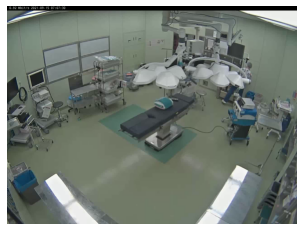

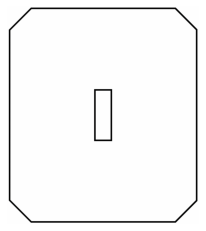

In [3]:
# open video and image
video = Capture(video_path)
frame = video.read()
utils.show_img(frame)

field = cv2.imread(field_path)
utils.show_img(field)

# ビデオ側の点を決定する
## ベッドを検出

In [4]:
hsv_range = {
    'min': np.array((0, 0, 50)),
    'max': np.array((180, 71, 81))
}
area = {
    'min': [490, 380],
    'max': [830, 600]
}

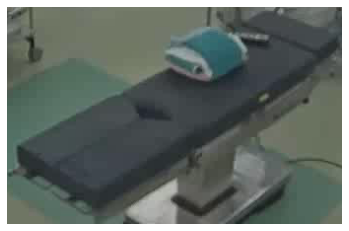

In [5]:
crop = frame[area['min'][1]:area['max'][1], area['min'][0]:area['max'][0]]
utils.show_img(crop)

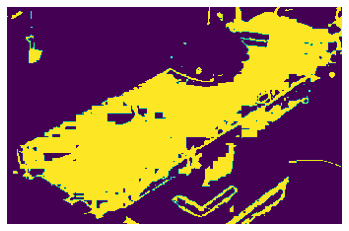

In [6]:
# rgb 2 hsv
hsv = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV)
hsv = cv2.inRange(hsv, hsv_range['min'], hsv_range['max'])
utils.show_img(hsv)

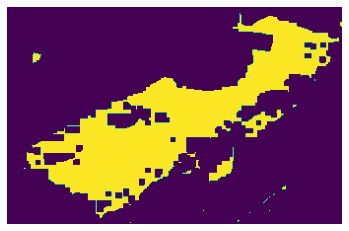

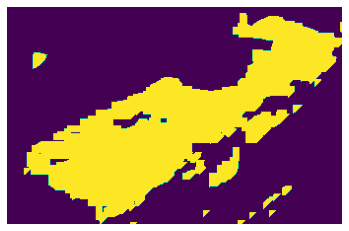

In [7]:
# noize reduction
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
erode = cv2.erode(hsv, kernel, iterations=4)
utils.show_img(erode)


kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2))
dilate = cv2.dilate(erode, kernel, iterations=6)
utils.show_img(dilate)

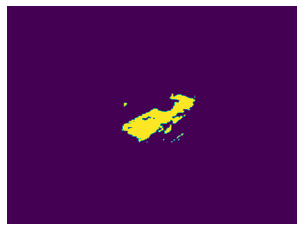

In [8]:
# create mask
mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
mask[area['min'][1]:area['max'][1], area['min'][0]:area['max'][0]] = dilate
utils.show_img(mask)

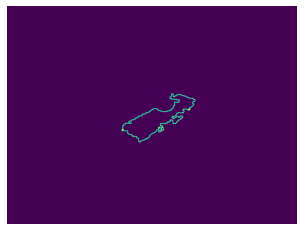

In [9]:
test = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)

# find contours
cnts, h = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# remove small area
cnts = list(filter(lambda x: cv2.contourArea(x) > 10000, cnts))

# draw
cv2.drawContours(test, cnts, -1, color=255, thickness=2)

utils.show_img(test)

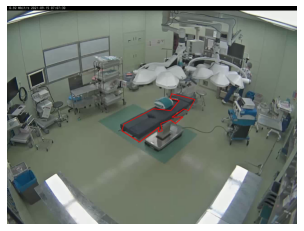

In [10]:
test = frame.copy()

cnt = cnts[0]
arclen = cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, arclen * 0.01, True)
approx = approx.reshape(-1, 2)

cv2.polylines(test, [approx], True, 255, thickness=2, lineType=cv2.LINE_8)
utils.show_img(test)

## 4点を決める

In [11]:
pred = KMeans(n_clusters=4).fit_predict(approx)
pred

array([0, 3, 3, 0, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0])

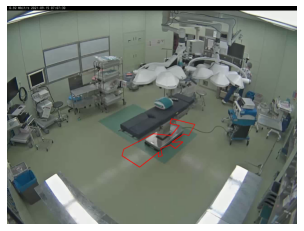

[[829 521]
 [726 496]
 [719 517]
 [760 526]
 [723 570]
 [646 562]
 [515 630]
 [507 659]
 [585 709]
 [670 643]
 [668 664]
 [685 659]
 [678 627]
 [721 611]
 [743 627]
 [776 598]
 [728 599]
 [780 563]
 [802 570]]


In [12]:
test = frame.copy()

y_length = 110
new_approx = approx.copy()
new_approx[:, 1] += y_length

cv2.polylines(test, [new_approx], True, 255, thickness=2, lineType=cv2.LINE_8)
utils.show_img(test)
print(new_approx)

In [13]:
x_min, y_min = np.min(new_approx, axis=0)
x_max, y_max = np.max(new_approx, axis=0)

In [14]:
[[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]

[[507, 496], [829, 496], [829, 709], [507, 709]]

# フィールド側の点を決定する

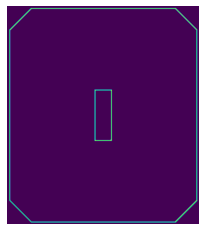

In [15]:
# rgb 2 gray
gray = cv2.cvtColor(field, cv2.COLOR_RGB2GRAY)
gray = cv2.bitwise_not(gray)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (4, 4))
gray = cv2.erode(gray, kernel, 1)
utils.show_img(gray)

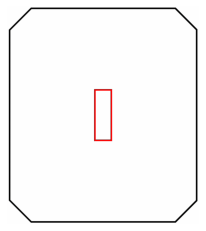

In [16]:
test = field.copy()

# find contours
lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi / 2, threshold=10, minLineLength=30, maxLineGap=0)

# draw
rect_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    length = np.linalg.norm((x1 - x2, y1 - y2))
    if length < 200:
        test = cv2.line(test, (x1, y1), (x2, y2), 255, 2)
        rect_lines.append(line[0])

utils.show_img(test)

In [17]:
rect_lines

[array([338, 515, 338, 320], dtype=int32),
 array([399, 515, 399, 320], dtype=int32),
 array([401, 515, 401, 320], dtype=int32),
 array([337, 515, 337, 320], dtype=int32),
 array([336, 515, 336, 319], dtype=int32),
 array([400, 515, 400, 319], dtype=int32),
 array([339, 513, 398, 513], dtype=int32),
 array([339, 320, 398, 320], dtype=int32),
 array([339, 515, 398, 515], dtype=int32),
 array([339, 514, 398, 514], dtype=int32),
 array([339, 321, 398, 321], dtype=int32),
 array([339, 322, 398, 322], dtype=int32)]

In [18]:
x_min, y_min = np.min(np.array(rect_lines).reshape(-1, 2), axis=0)
x_max, y_max = np.max(np.array(rect_lines).reshape(-1, 2), axis=0)

In [19]:
[[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]

[[336, 319], [401, 319], [401, 515], [336, 515]]

# 検証

In [1]:
import sys
import cv2

sys.path.append('../../src')
from common import common, utils, transform, video
from common.transform import Homography
import cv2

C:\Users\k2111\program\research/video/02/20210903/01.mp4
C:\Users\k2111\program\research\data/02/field.png


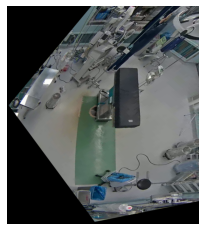

In [3]:
# file path
room_num = "02"
date = "20210903"
video_path = common.root + f"/video/{room_num}/{date}/01.mp4"
field_path = common.data_dir + "/{}/field.png".format(room_num)
print(video_path)
print(field_path)

# open video and image
cap = video.Capture(video_path)
frame = cap.read()

field = cv2.imread(field_path)

p_video = transform.homo[room_num][0]
p_field = transform.homo[room_num][1]
homo = Homography(p_video, p_field, field.shape)
frame = homo.transform_image(frame)
utils.show_img(frame)